# Breakthrough model 1


author: bebu

date: 18.09.2025

description: Simple model to calculate the spacial (1D) co2 concentration in a breakthrough column (in air flow direction) and over time. All values are calculated per squaremeter of inlet area. Assumptions this model relies on:
- air flow in equals air flow out (i.e. the amound of co2 molecules being taken up in the column is neglegitable compared to the total amount of air molecules)
- the mass transfer coefficient (MTC) K_initial [mmol/(m^2 s kPa)] stays constant throughout time (i.e. it does not change with loading OR loading is constant throughout time as it would be in continuous operation.)

## Imports & Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import time

def K_eff(uptake, K_initial, cap, V_liq):
    """Calculate effective mass transfer coefficient based on current uptake.
    
    Args:
        uptake (float): Current uptake in mol.
        K_initial (float): Initial mass transfer coefficient in mmol/(m^2 s kPa).
        cap (float): Cyclic uptake capacity in mol/L.
        V_liq (float): Liquid sorbent volume in L.
        N (int): Number of sections in the column.
        
    Returns:
        float: Effective mass transfer coefficient in mmol/(m^2 s kPa).
    """
    if uptake >= cap * V_liq:
        return 0.0
    else:
        return K_initial * (1 - uptake / (cap * V_liq))
    

def plot_model_results(x, n2l, l, v, SSA, dt, ds):
    # Custom colormap
    cmap = LinearSegmentedColormap.from_list("blue_yellow", ["blue", "yellow"])
    l_N = l / n2l.shape[1] # l/ N
    p = int(np.ceil(ds)) # number of sections before inlet (for airspeeds larger than l_N/dt)
    
    # --- Figure with GridSpec: 3 rows, 2 cols ---
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(4, 3, width_ratios=[20, 1, 1], height_ratios=[2, 1, 2, 1])
    
    ax1 = fig.add_subplot(gs[0, 0])          # full heatmap
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # outlet profile
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)  # tail heatmap
    ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)  # tail heatmap
    cax = fig.add_subplot(gs[:, 1])          # colorbar (shared)
    cax2 = fig.add_subplot(gs[:, 2])          # colorbar uptake (shared)
    
    # --- Top: full heatmap ---
    im = ax1.imshow(
        x[:,p-1:].T * 10, 
        cmap="Reds", vmin=0, vmax=400,
        interpolation="nearest", origin="lower", aspect="auto",
    
    )
    ax1.set_title(f"Breakthrough column\nl: {l} m, v: {v} m/s, SSA: {SSA} m$^2$/m$^3$")
    ax1.set_ylabel(f"segment # (bottom: air in, top: air out)\n"
                   f"each segment corresponds to {l_N} m")
    ax1.set_xticks(np.arange(x.shape[0]))                       # ticks at 0..N-1
    ax1.set_xticklabels(np.arange(1, x.shape[0] + 1))           # labels 1..N
    ax1.locator_params(axis="x", nbins=6)  # at most 6 ticks
    
    # --- Middle: outlet + CF ---
    line1, = ax2.plot(x[:, -1]*10, color="black", label="outlet CO$_2$")
    ax2.set_ylabel("outlet CO$_2$\n[ppm]", color="black")
    
    ax2b = ax2.twinx()
    cf = (400 - x[:, -1]*10) / 4
    line2, = ax2b.plot(cf, color="red", label="CF")
    ax2b.set_ylabel("CF [%]", color="red")
    
    ax2.tick_params(axis='y', colors=line1.get_color())
    ax2b.tick_params(axis='y', colors=line2.get_color())
    
    # --- Bottom middle: tail heatmap ---
    im2 = ax3.imshow(
        n2l[:, :].T,
        cmap="Greens", vmin=0, vmax=n2l.max(),
        interpolation="nearest", origin="lower", aspect="auto"
    )
    ax3.set_title(f"uptake")
    ax3.set_xlabel(f"time (x {dt} s)")
    ax3.set_ylabel(f"tail section (segment {p} onward)\n{l_N} m each")
    ax3.set_ylabel(f"segment # (bottom: air in, top: air out)\n"
                   f"each segment corresponds to {l_N} m")
    ax3.set_yticks(np.arange(n2l.shape[1]))                       # ticks at 0..N-1
    ax3.set_yticklabels(np.arange(1, n2l.shape[1] + 1))           # labels 1..N
    ax3.locator_params(axis="y", nbins=6)  # at most 6 ticks
    
    line3, = ax4.plot(np.sum(n2l, axis=1), color="green", label="outlet CO$_2$")
    ax4.set_ylabel(f"instant. uptake\n[mol/{dt}s]", color="green")
    
    ax4b = ax4.twinx()
    n_total = integrated = np.cumsum(np.sum(n2l, axis=1))
    line4, = ax4b.plot(n_total, color="black", label="cum. uptake")
    ax4b.set_ylabel("cum. uptake\n[mol]", color="black")
    #
    ax4.tick_params(axis='y', colors=line3.get_color())
    ax4b.tick_params(axis='y', colors=line4.get_color())
    
    # --- Shared colorbar ---
    fig.colorbar(im, cax=cax, label=f"gas phase CO$_2$ concentration [ppm]")
    fig.colorbar(im2, cax=cax2, label=f"uptake of co2 [mol] (per {dt} s and $m^2$ inlet area)")
    
    plt.tight_layout()
    plt.show()

def run_model(
        K_initial, 
        l, 
        SSA, 
        v, 
        dt, 
        N, 
        T, 
        eps=0.8, # wetting efficiency element [0, 1]
        ):
    # derived parameters
    l_N = l/N # length of one section [m]
    V_N = l_N # volume of one section [m^3]
    ds = v * dt / l_N # number of sections (that air travels in one time step)
    ds_int_flag = ds.is_integer() # flag if ds is integer
    #p = 2 # number of sections before inlet (for airspeeds larger than l_N/dt) -> could be set to np.ceil(ds)
    p = int(np.ceil(ds)) # number of sections before inlet (for airspeeds larger than l_N/dt)
    if ds_int_flag:
        print(f"ds = {ds} is integer.")
    print(f"ds: {ds} [segments per timesteps], -> p: {p} [segments before inlet]")

    # concentration matrix
    x = np.ones((T, N+p)) * np.nan # [Pa]. rows: time steps; collumns: sections

    # set initial and boundary conditions: 
    # 1) x = 40 Pa for all time steps(=rows) at inlet (p initial sections=columns);
    x[:, 0:p] = 40 # initial concentration in inlet [Pa]
    # 2) x = 40 Pa at t=0 for all sections:columns
    x[0, :] = 40 # initial concentration in collumn [Pa]
    x

    # mol in gase phase matrix (mol per time step and section)
    n = np.ones((T, N)) * np.nan # rows: time steps; collumns: sections
    # uptake matrix (mol per time step and section)
    n2l = np.ones((T, N)) * np.nan # rows: time steps; collumns: sections

    # total uptake (over time)
    n_total_t = np.zeros(T) # total uptake per time step [mol]
    for t in range(0, T):
        #print(f"t = {t}")
        # 1) calculate uptake n for section i at time step t
        n2l[t, :] = x[t,p:N+p] * eps * K_initial * 1e-6 * SSA * l_N * dt # uptake gas molecules to liquid [mol]
        #print(f"n2l = {n2l}")
        n[t, :] = x[t,p:N+p] * V_N / (8.314 * 298) - n2l[t, :]# remaining in gas phase [mol]
        if (n[t, :] < 0.0).any(): # check if remaining in gas phase is negative
            print(f"Warning: negative remaining in gas phase! setting to zero. time step: {t}, index: {np.where(n[t, :] < 0.0)}")
            n2l[t, n[t, :] < 0.0] = x[t,p:N+p][n[t, :] < 0.0] * V_N / (8.314 * 298) # limit uptake to remaining in gas phase
            n[t, n[t, :] < 0.0] = 0.0
        #n2l[t, :] = x[t,p:N+p] * K_initial * 1e-6 * SSA * l_N * dt * 44 # uptake [g_co2]

        # 2) calc remaining concentration after uptake:
        x[t, p:N+p] = n[t, :] * 8.314 * 298 / (V_N) # new concentration [Pa]
        #print(f"calculated remaind partial pressure in gasphase (at end of timestep {t}): {x[t, p:N+p]}")

        if t < T - 1:
            # 3) calc next concentration x for all sections (p:N+p) at time step t+1
            if ds_int_flag:# if ds is int(ds)
                x[t+1, p:N+p] = x[t, (p-int(ds)):(N+p-int(ds))] # new concentration (in next time step) equals the one in segment ds (integer) steps back (in this timestep)
            else: 
                x[t+1, p:N+p] = x[t, (p-int(np.floor(ds))):(N+p-int(np.floor(ds)))]*(np.ceil(ds) - ds) + x[t, (p-int(np.ceil(ds))):(N+p-int(np.ceil(ds)))]*(ds - np.floor(ds)) # new concentration (in next time step) equals a mix of the concentation in the two segments that are ceil(ds) and floor(ds) steps back
    
    return x, n2l, n, ds

In [2]:
# parameter recommendation: dt < 1e6/(RT K eps SSA) = ca 
1e6/(8.314*300*1.5*0.8*210)

1.5909926903431835

## Set parameter, run model

Running simulation for 2 seconds. [model parameter: Npm=100; dt=0.001 s]
ds: 0.1 [segments per timesteps], -> p: 1 [segments before inlet]
LAST STATE: CF=46.36%; inst. uptake=7.48mmol/second


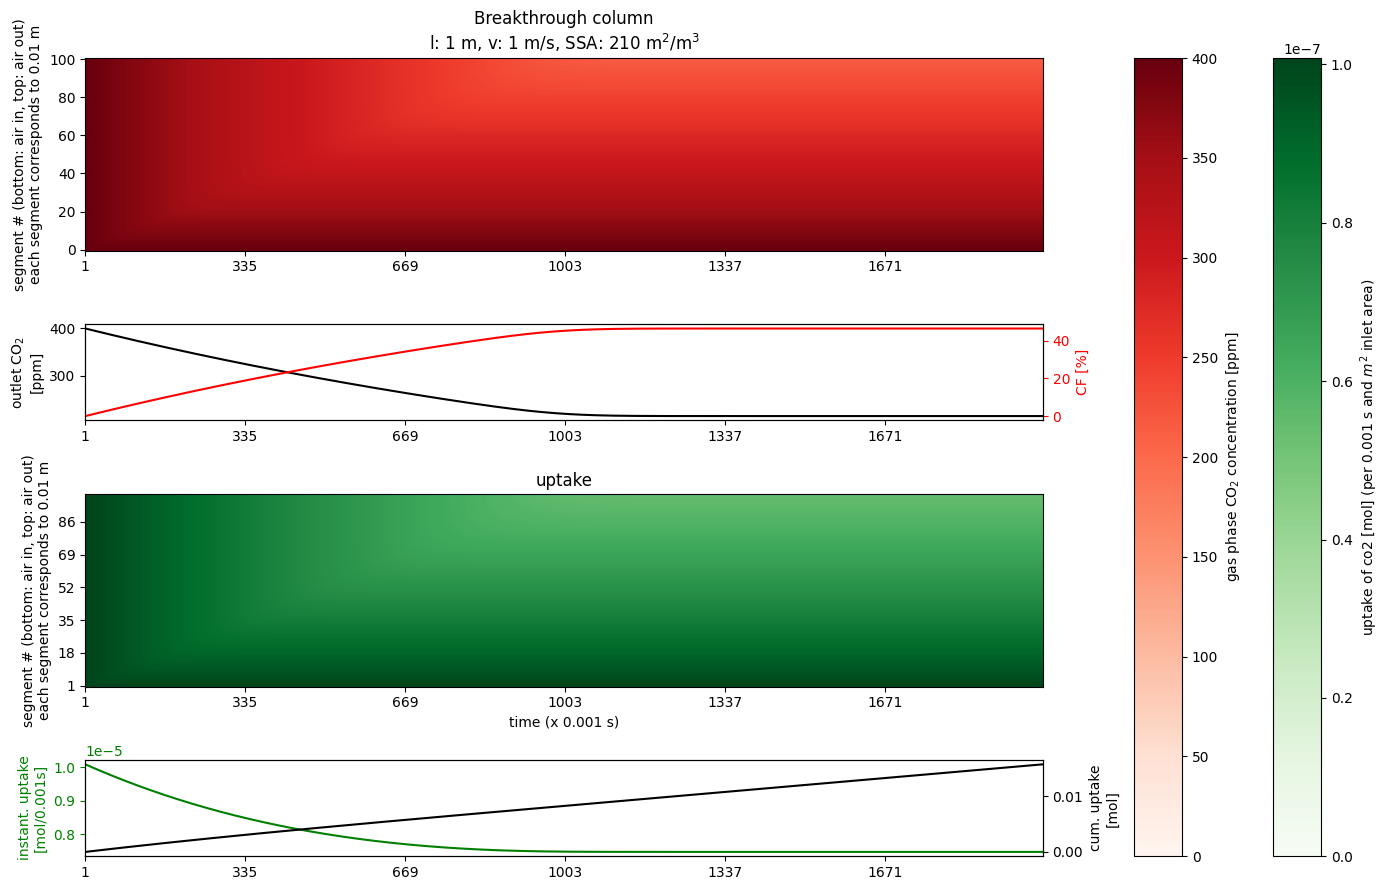

In [3]:
# sorbent parameters
K_initial = 1.5 # initial mass transfer coefficient [mmol/(m^2 s kPa)]
#cap = 2.0 # cyclic uptake capacity [mol/L]

# process design parameters
l = 1 # collumn depth [m]
SSA = 210 # sorbent specific surface area [m^2/m^3]
eps = 0.8
# process operation parameters
v = 1 # air speed [m/s]
#V_liq = 0.5 # liquid sorbent volume [L]

# model parameters
dt = 0.001 # time step [s]
Npm = 100 # number of sections per meter
N = int(Npm * l) # number of sections in the collumn
duration = 2 # s
T = int(duration/dt) # total simulation time steps

print(f"Running simulation for {duration} seconds. [model parameter: Npm={Npm}; dt={dt} s]")

x, n2l, n, ds = run_model(
    # sorbent parameters
    K_initial=K_initial,    # initial mass transfer coefficient [mmol/(m^2 s kPa)]

    # process design parameters
    l = l, # collumn depth [m]
    SSA = SSA, # sorbent specific surface area [m^2/m^3]
    # process operation parameters
    v = v, # air speed [m/s]
    eps = 0.8, # wetting efficiency [-] between 0 and 1

    # model parameters
    N = N, # number of sections in the collumn
    T = T, # total simulation time steps
    dt = dt, # time step [s]
    )

cf = (400 - x[:, -1]*10) / 4 # capture fraction in %
# check if cf's are equal up to rtol=0.1% (for individual entries):
# consecutive-row differences
#diff = np.abs(cf[1:] - cf[:-1])
# per-entry condition: |Δ| ≤ rtol*|prev| 
#same_row_follows_mask = diff <= 0.0001 * np.abs(cf[:-1])

inst_uptake = np.sum(n2l, axis=1) # uptake in mol per timestep
#if np.any(same_row_follows_mask):
#    first_row = np.argmax(same_row_follows_mask) # first row that is steady state
#    #print("run reached STEADY STATE! (i.e. concentation in setup equal over last 2 timesteps)")
#    #print(f"First steady state timestep is {first_row + 1} (equal to timestep {first_row+2})")
#    if not np.all(same_row_follows_mask[first_row:]): 
#        raise ValueError("Not all rows are equal after first steady state...")
#    print(f"STEADY STATE: CF={cf[first_row]:.2f}%; inst. uptake={inst_uptake[first_row]:.3g}mol/timestep; first steady state timestep: {first_row + 1}")
#else:
#    print("Warning: run did not reach steady state. (i.e. concentation in setup NOT equal over last 2 timesteps)")
print(f"LAST STATE: CF={cf[-1]:.2f}%; inst. uptake={inst_uptake[-1]/dt *1000:.3g}mmol/second")
plot_model_results(x, n2l, l, v, SSA, dt, ds)

In [4]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# Parameter sweep definition
# --------------------------
Npm_list = [1, 10, 100, 1000]
#Npm_list = [1, 2]
dt_list  = [1.0, 0.1, 0.01, 0.001, 0.0001]  # kept as given (includes duplicate 0.001)
#dt_list  = [1.0, 0.1]  # kept as given (includes duplicate 0.001)

# --------------------------
# Fixed/problem parameters (edit if needed)
# --------------------------
duration = 2.0  # [s]
eps = 0.8       # wetting efficiency [-]

# Assumes these exist in your environment (as in your example):
# K_initial, l, SSA, v, run_model(...)

results = []

for Npm in Npm_list:
    for dt in dt_list:
        N = int(Npm * l)                     # number of axial sections
        T = int(duration / dt)               # number of timesteps

        # --- time the model execution
        t0 = time.perf_counter()
        x, n2l, n, ds = run_model(
            # sorbent
            K_initial=K_initial,          # [mmol/(m^2 s kPa)]
            # process design
            l=l,                          # [m]
            SSA=SSA,                      # [m^2/m^3]
            # operation
            v=v,                          # [m/s]
            eps=eps,                      # [-]
            # model
            N=N,                          # [-]
            T=T,                          # [-]
            dt=dt                         # [s]
        )
        t1 = time.perf_counter()
        calc_time = t1 - t0

        # --- metrics
        # capture fraction at final time step (your definition)
        cf = (400 - x[:, -1] * 10) / 4             # (%) per section
        cf_last = cf[-1] if cf.ndim == 1 else np.asarray(cf).ravel()[-1]

        # instantaneous uptake: sum over species (?) per timestep; last timestep, then /dt
        inst_uptake = np.sum(n2l, axis=1)          # shape (T,)
        inst_uptake_rate_last = inst_uptake[-1] / dt

        results.append({
            "Npm": Npm,
            "dt": dt,
            "N": N,
            "T": T,
            "calc_time_s": calc_time,
            "inst_uptake_last_over_dt": inst_uptake_rate_last,
            "cf_last_percent": cf_last
        })

# --------------------------
# Collect results
# --------------------------
df = pd.DataFrame(results).sort_values(["dt", "Npm"]).reset_index(drop=True)
print(df)

df.to_csv(r"model_results\model1\df_model1p0_validation_02")



ds = 1.0 is integer.
ds: 1.0 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.1 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.01 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.001 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.0001 [segments per timesteps], -> p: 1 [segments before inlet]
ds = 10.0 is integer.
ds: 10.0 [segments per timesteps], -> p: 10 [segments before inlet]
ds = 1.0 is integer.
ds: 1.0 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.09999999999999999 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.01 [segments per timesteps], -> p: 1 [segments before inlet]
ds: 0.001 [segments per timesteps], -> p: 1 [segments before inlet]
ds = 100.0 is integer.
ds: 100.0 [segments per timesteps], -> p: 100 [segments before inlet]
ds = 10.0 is integer.
ds: 10.0 [segments per timesteps], -> p: 10 [segments before inlet]
ds = 1.0 is integer.
ds: 1.0 [segments per timesteps], -> p: 1 [se

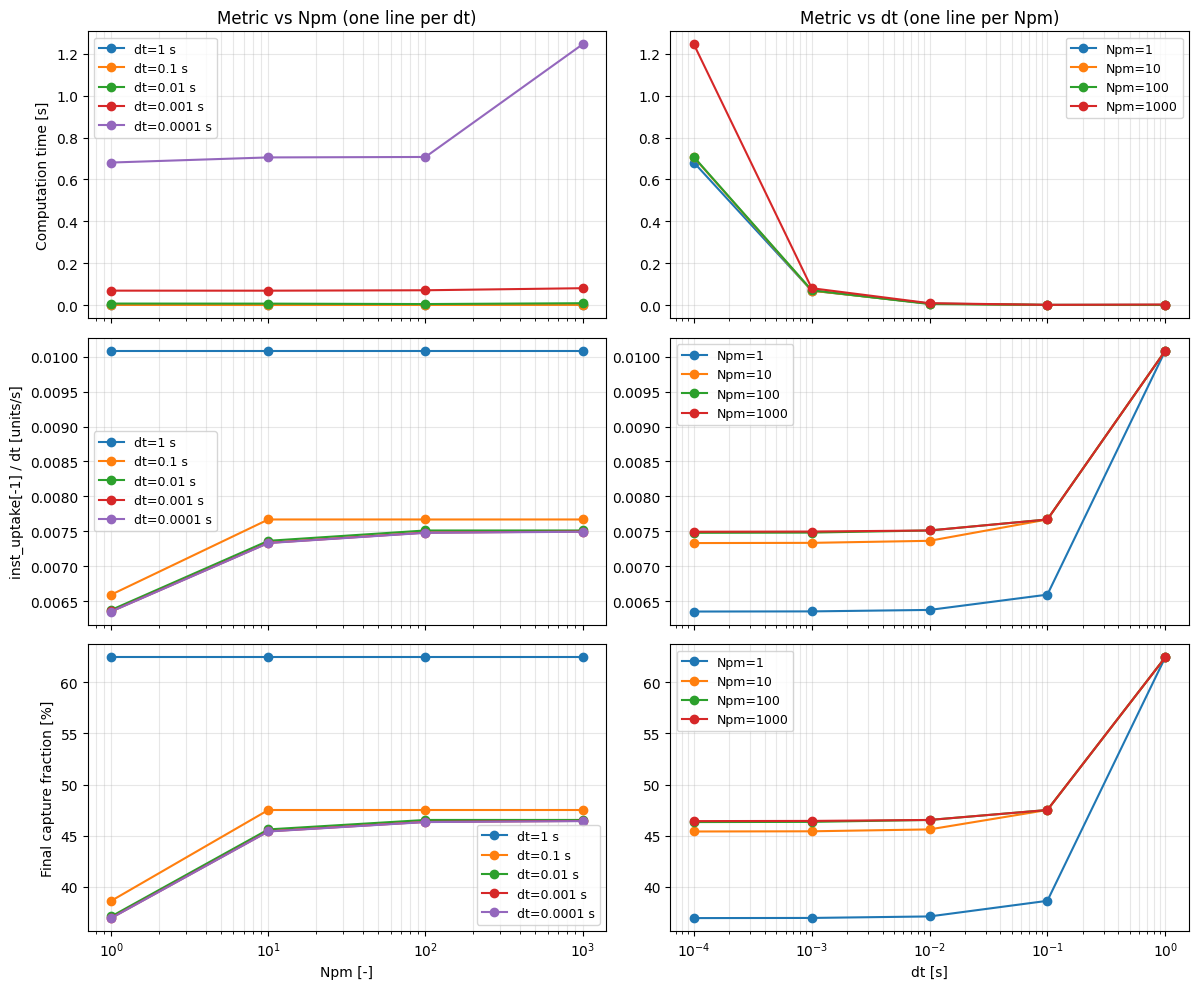

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# --- metrics config (as in your code) ---
metrics = [
    ("calc_time_s", "Computation time [s]"),
    ("inst_uptake_last_over_dt", "inst_uptake[-1] / dt [units/s]"),
    ("cf_last_percent", "Final capture fraction [%]"),
]

# Deduplicate dt for legend/lines
unique_dt = []
for d in dt_list:
    if d not in unique_dt:
        unique_dt.append(d)
unique_Npm = Npm_list

# --- figure & axes ---
fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(12, 10),
    sharex='col',  # share within each column
)

# Column titles
axes[0, 0].set_title("Metric vs Npm (one line per dt)")
axes[0, 1].set_title("Metric vs dt (one line per Npm)")

# Formatters to avoid scientific notation on y by default
yfmt = ScalarFormatter()
yfmt.set_useOffset(False)
yfmt.set_scientific(False)

# ---- Left column: x = Npm, one line per dt ----
for row_idx, (mkey, mlabel) in enumerate(metrics):
    ax = axes[row_idx, 0]
    for d in unique_dt:
        sub = df[df["dt"] == d].sort_values("Npm")
        if len(sub) == 0:
            continue
        ax.plot(sub["Npm"], sub[mkey], marker="o", label=f"dt={d:g} s")
    ax.set_ylabel(mlabel)
    ax.grid(True, which="both", alpha=0.3)
    ax.set_xscale("log")  # Npm spans 1→1000
    ax.yaxis.set_major_formatter(yfmt)
    ax.legend(loc="best", fontsize=9)

# X label only on bottom-left
axes[-1, 0].set_xlabel("Npm [-]")

# ---- Right column: x = dt, one line per Npm ----
for row_idx, (mkey, mlabel) in enumerate(metrics):
    ax = axes[row_idx, 1]
    for npmi in unique_Npm:
        sub = df[df["Npm"] == npmi].sort_values("dt")
        if len(sub) == 0:
            continue
        ax.plot(sub["dt"], sub[mkey], marker="o", label=f"Npm={npmi}")
    ax.grid(True, which="both", alpha=0.3)
    ax.set_xscale("log")  # dt spans orders of magnitude
    ax.yaxis.set_major_formatter(yfmt)
    ax.legend(loc="best", fontsize=9)

# X label only on bottom-right
axes[-1, 1].set_xlabel("dt [s]")

# Tidy layout
plt.tight_layout()
plt.show()


## old tests

Running simulation for 2 seconds. [model parameter: Npm=100; dt=0.001 s]
ds: 0.1 [segments per timesteps], -> p: 1 [segments before inlet]
STEADY STATE: CF=46.12%; inst. uptake=7.49e-06mol/timestep; first steady state timestep: 1100


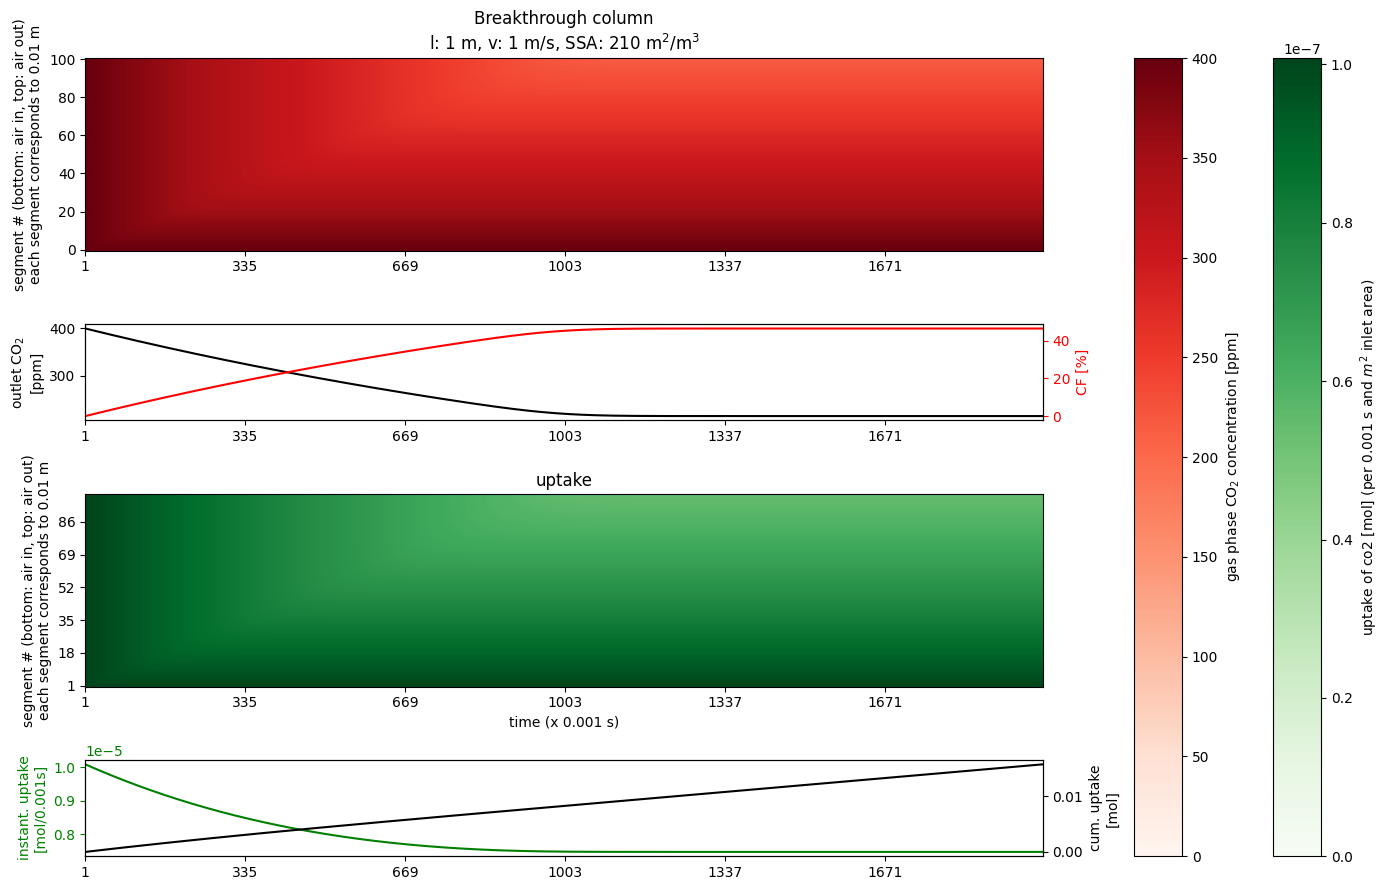

In [7]:
# sorbent parameters
K_initial = 1.5 # initial mass transfer coefficient [mmol/(m^2 s kPa)]
#cap = 2.0 # cyclic uptake capacity [mol/L]

# process design parameters
l = 1 # collumn depth [m]
SSA = 210 # sorbent specific surface area [m^2/m^3]
eps = 0.8
# process operation parameters
v = 1 # air speed [m/s]
#V_liq = 0.5 # liquid sorbent volume [L]

# model parameters
dt = 0.001 # time step [s]
Npm = 100 # number of sections per meter
N = int(Npm * l) # number of sections in the collumn
duration = 2 # s
T = int(duration/dt) # total simulation time steps

print(f"Running simulation for {duration} seconds. [model parameter: Npm={Npm}; dt={dt} s]")

x, n2l, n, ds = run_model(
    # sorbent parameters
    K_initial=K_initial,    # initial mass transfer coefficient [mmol/(m^2 s kPa)]

    # process design parameters
    l = l, # collumn depth [m]
    SSA = SSA, # sorbent specific surface area [m^2/m^3]
    # process operation parameters
    v = v, # air speed [m/s]
    eps = 0.8, # wetting efficiency [-] between 0 and 1

    # model parameters
    N = N, # number of sections in the collumn
    T = T, # total simulation time steps
    dt = dt, # time step [s]
    )

cf = (400 - x[:, -1]*10) / 4 # capture fraction in %
# check if cf's are equal up to rtol=0.1% (for individual entries):
# consecutive-row differences
diff = np.abs(cf[1:] - cf[:-1])
# per-entry condition: |Δ| ≤ rtol*|prev| 
same_row_follows_mask = diff <= 0.0001 * np.abs(cf[:-1])

inst_uptake = np.sum(n2l, axis=1) # uptake in mol per timestep
if np.any(same_row_follows_mask):
    first_row = np.argmax(same_row_follows_mask) # first row that is steady state
    #print("run reached STEADY STATE! (i.e. concentation in setup equal over last 2 timesteps)")
    #print(f"First steady state timestep is {first_row + 1} (equal to timestep {first_row+2})")
    if not np.all(same_row_follows_mask[first_row:]): 
        raise ValueError("Not all rows are equal after first steady state...")
    print(f"STEADY STATE: CF={cf[first_row]:.2f}%; inst. uptake={inst_uptake[first_row]:.3g}mol/timestep; first steady state timestep: {first_row + 1}")
else:
    print("Warning: run did not reach steady state. (i.e. concentation in setup NOT equal over last 2 timesteps)")
    print(f"LAST STATE: CF={cf[-1]:.2f}%; inst. uptake={inst_uptake[-1]/dt:.3g}mol/second")
plot_model_results(x, n2l, l, v, SSA, dt, ds)

ds: 0.005714285714285714 [segments per timesteps], -> p: 1 [segments before inlet]
STEADY STATE: CF=93.78%; inst. uptake=0.000157mol/timestep; first steady state timestep: 582


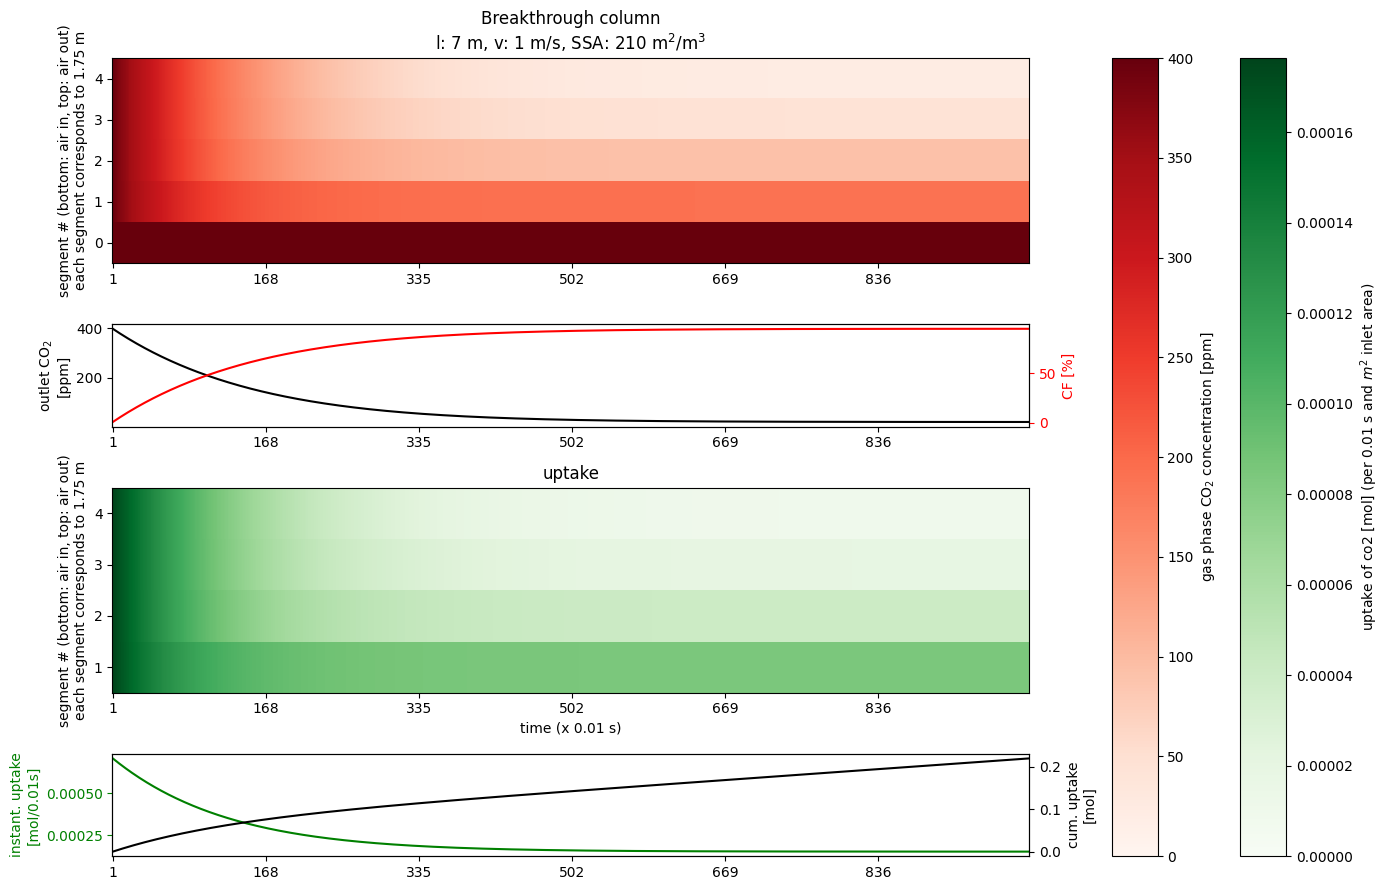

In [8]:
# model parameters
dt = 0.01 # time step [s]
N = 4 # number of sections in the collumn
duration = 10 # s
T = int(duration/dt) # total simulation time steps

# sorbent parameters
K_initial = 1.5 # initial mass transfer coefficient [mmol/(m^2 s kPa)]
cap = 2.0 # cyclic uptake capacity [mol/L]

# process design parameters
l = 7 # collumn depth [m]
SSA = 210 # sorbent specific surface area [m^2/m^3]
eps = 0.8
# process operation parameters
v = 1 # air speed [m/s]
V_liq = 0.5 # liquid sorbent volume [L]

x, n2l, n, ds = run_model(
    # sorbent parameters
    K_initial=K_initial,    # initial mass transfer coefficient [mmol/(m^2 s kPa)]

    # process design parameters
    l = l, # collumn depth [m]
    SSA = SSA, # sorbent specific surface area [m^2/m^3]
    # process operation parameters
    v = v, # air speed [m/s]
    eps = 0.8, # wetting efficiency [-] between 0 and 1

    # model parameters
    N = N, # number of sections in the collumn
    T = T, # total simulation time steps
    dt = dt, # time step [s]
    )

cf = (400 - x[:, -1]*10) / 4 # capture fraction in %
# check if cf's are equal up to rtol=0.1% (for individual entries):
# consecutive-row differences
diff = np.abs(cf[1:] - cf[:-1])
# per-entry condition: |Δ| ≤ rtol*|prev| 
same_row_follows_mask = diff <= 0.0001 * np.abs(cf[:-1])

inst_uptake = np.sum(n2l, axis=1) # uptake in mol per timestep
if np.any(same_row_follows_mask):
    first_row = np.argmax(same_row_follows_mask) # first row that is steady state
    #print("run reached STEADY STATE! (i.e. concentation in setup equal over last 2 timesteps)")
    #print(f"First steady state timestep is {first_row + 1} (equal to timestep {first_row+2})")
    if not np.all(same_row_follows_mask[first_row:]): 
        raise ValueError("Not all rows are equal after first steady state...")
    print(f"STEADY STATE: CF={cf[first_row]:.2f}%; inst. uptake={inst_uptake[first_row]:.3g}mol/timestep; first steady state timestep: {first_row + 1}")
else:
    print("Warning: run did not reach steady state. (i.e. concentation in setup NOT equal over last 2 timesteps)")
    print(f"LAST STATE: CF={cf[-1]:.2f}%; inst. uptake={inst_uptake[-1]:.3g}mol/timestep")
plot_model_results(x, n2l, l, v, SSA, dt, ds)

ds: 0.005714285714285714 [segments per timesteps], -> p: 1 [segments before inlet]
STEADY STATE: CF=85.89%; inst. uptake=0.000188mol/timestep; first steady state timestep: 328


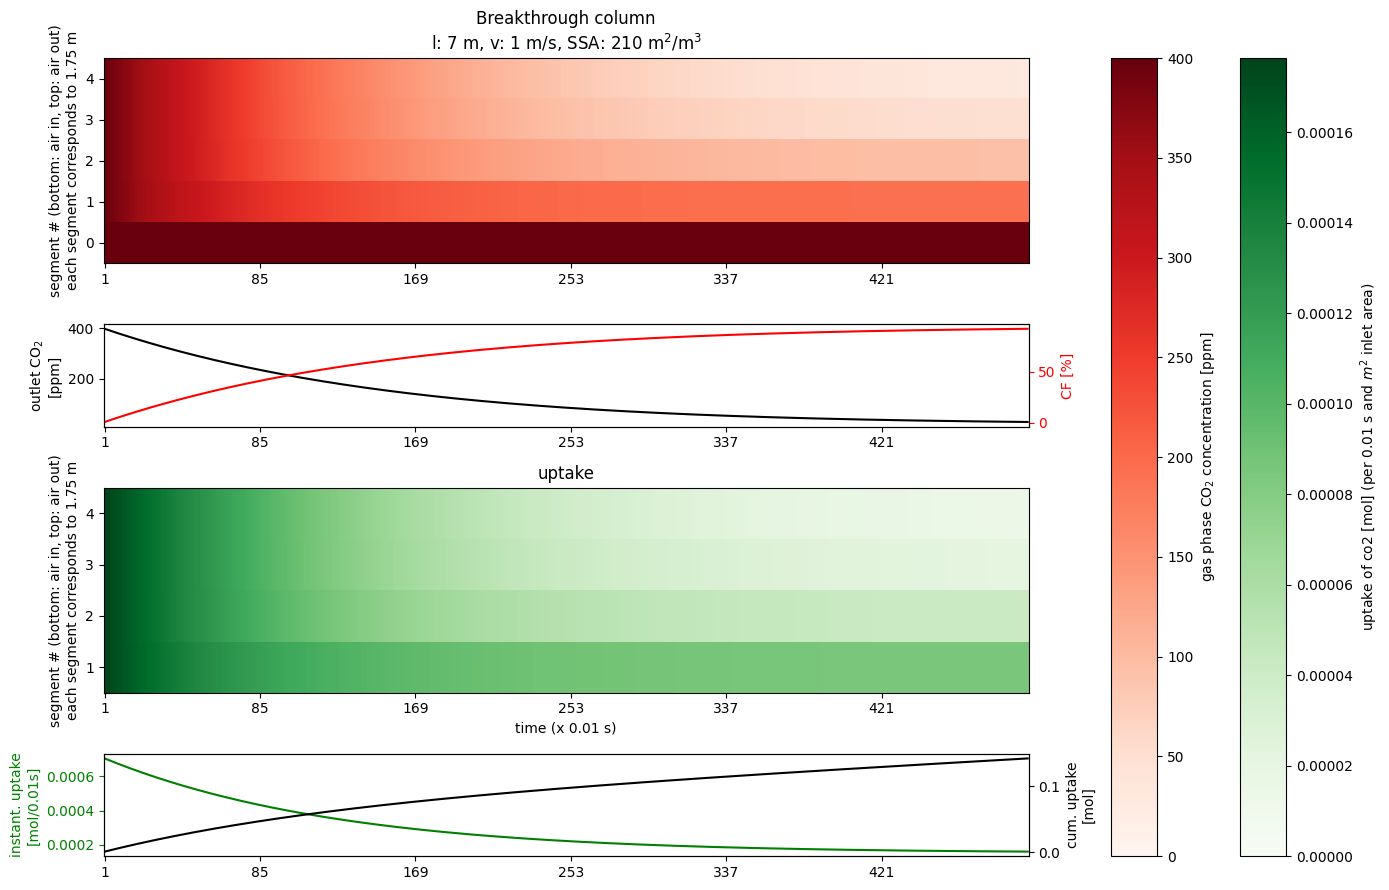

In [9]:
# model parameters
dt = 0.01 # time step [s]
N = 4 # number of sections in the collumn
duration = 5 # s
T = int(duration/dt) # total simulation time steps

# sorbent parameters
K_initial = 1.5 # initial mass transfer coefficient [mmol/(m^2 s kPa)]
cap = 2.0 # cyclic uptake capacity [mol/L]

# process design parameters
l = 7 # collumn depth [m]
SSA = 210 # sorbent specific surface area [m^2/m^3]
eps = 0.8
# process operation parameters
v = 1 # air speed [m/s]
V_liq = 0.5 # liquid sorbent volume [L]

x, n2l, n, ds = run_model(
    # sorbent parameters
    K_initial=K_initial,    # initial mass transfer coefficient [mmol/(m^2 s kPa)]

    # process design parameters
    l = l, # collumn depth [m]
    SSA = SSA, # sorbent specific surface area [m^2/m^3]
    # process operation parameters
    v = v, # air speed [m/s]
    eps = 0.8, # wetting efficiency [-] between 0 and 1

    # model parameters
    N = N, # number of sections in the collumn
    T = T, # total simulation time steps
    dt = dt, # time step [s]
    )

#same_row_follows_mask = np.all(x[1:] == x[:-1], axis=1)

# check if rows are equal up to rtol=0.1% (for individual entries):
# consecutive-row differences
diff = np.abs(x[1:] - x[:-1])
# per-entry condition: |Δ| ≤ rtol*|prev| 
per_entry_ok = diff <= 0.005 * np.abs(x[:-1])
# a row “follows equal” if ALL its entries satisfy the tolerance
same_row_follows_mask = per_entry_ok.all(axis=1)
if np.any(same_row_follows_mask):
    first_row = np.argmax(same_row_follows_mask) # first row that is steady state
    #print("run reached STEADY STATE! (i.e. concentation in setup equal over last 2 timesteps)")
    #print(f"First steady state timestep is {first_row + 1} (equal to timestep {first_row+2})")
    if not np.all(same_row_follows_mask[first_row:]): 
        raise ValueError("Not all rows are equal after first steady state...")
    cf = (400 - x[:, -1]*10) / 4 # capture fraction in %
    inst_uptake = np.sum(n2l, axis=1) # uptake in mol per timestep
    print(f"STEADY STATE: CF={cf[first_row]:.2f}%; inst. uptake={inst_uptake[first_row]:.3g}mol/timestep; first steady state timestep: {first_row + 1}")
else:
    print("Warning: run did not reach steady state. (i.e. concentation in setup NOT equal over last 2 timesteps)")
plot_model_results(x, n2l, l, v, SSA, dt, ds)

In [10]:
cf

array([ 0.62434814,  1.24479818,  1.86137445,  2.47410114,  3.08300228,
        3.68810175,  4.28942329,  4.88699048,  5.48082674,  6.07095537,
        6.65739949,  7.24018208,  7.81932599,  8.39485389,  8.96678833,
        9.5351517 , 10.09996624, 10.66125407, 11.21903714, 11.77333725,
       12.32417608, 12.87157516, 13.41555586, 13.95613944, 14.49334698,
       15.02719946, 15.5577177 , 16.08492237, 16.60883403, 17.12947308,
       17.64685979, 18.1610143 , 18.67195661, 19.17970658, 19.68428396,
       20.18570834, 20.68399919, 21.17917585, 21.67125753, 22.16026331,
       22.64621214, 23.12912284, 23.6090141 , 24.08590451, 24.5598125 ,
       25.03075639, 25.49875439, 25.96382457, 26.42598488, 26.88525316,
       27.34164712, 27.79518434, 28.24588231, 28.69375839, 29.13882981,
       29.5811137 , 30.02062707, 30.45738681, 30.89140972, 31.32271245,
       31.75131157, 32.17722353, 32.60046466, 33.02105118, 33.43899924,
       33.85432482, 34.26704385, 34.67717212, 35.08472533, 35.48

In [11]:
n2l

array([[1.76400000e-04, 1.76400000e-04, 1.76400000e-04, 1.76400000e-04],
       [1.75304943e-04, 1.75298650e-04, 1.75298650e-04, 1.75298650e-04],
       [1.74222942e-04, 1.74204212e-04, 1.74204176e-04, 1.74204176e-04],
       ...,
       [8.47856917e-05, 4.12986359e-05, 2.15530733e-05, 1.30676150e-05],
       [8.47828690e-05, 4.12877346e-05, 2.15306344e-05, 1.30342132e-05],
       [8.47800800e-05, 4.12769473e-05, 2.15084011e-05, 1.30010822e-05]],
      shape=(500, 4))

In [12]:
x[2:]

array([[40.        , 39.25967897, 39.25545827, 39.25545022, 39.25545022],
       [40.        , 39.01876589, 39.01039152, 39.01035959, 39.01035954],
       [40.        , 38.78072499, 38.76687841, 38.76679932, 38.76679909],
       ...,
       [40.        , 19.10574462,  9.30630128,  4.85680432,  2.94467746],
       [40.        , 19.10510856,  9.30384476,  4.8517479 ,  2.93715064],
       [40.        , 19.10448008,  9.30141392,  4.84673782,  2.92968485]],
      shape=(498, 5))

In [13]:
(x*l/N/8.314 / 300)[:,2:]

array([[0.02788989, 0.02788989, 0.02788989],
       [0.02771576, 0.02771576, 0.02771576],
       [0.02754272, 0.02754271, 0.02754271],
       ...,
       [0.00652956, 0.00340767, 0.00206607],
       [0.00652784, 0.00340412, 0.00206079],
       [0.00652613, 0.00340061, 0.00205555]], shape=(500, 3))

In [14]:
(x*l/N/8.314 / 300)[:,2:] + n2l

ValueError: operands could not be broadcast together with shapes (500,3) (500,4) 

## assessment 1: do model parameter converge to same CF and instantaneous uptake for different 

-----------------------------> new model run: N=4, dt=0.01
ds: 0.04 [segments per timesteps], -> p: 1 [segments before inlet]
LAST STATE: CF=44.21%; inst. uptake=7.14e-05mol/timestep; calc-time=0.038s. size: 1000 timesteps x 5 segments


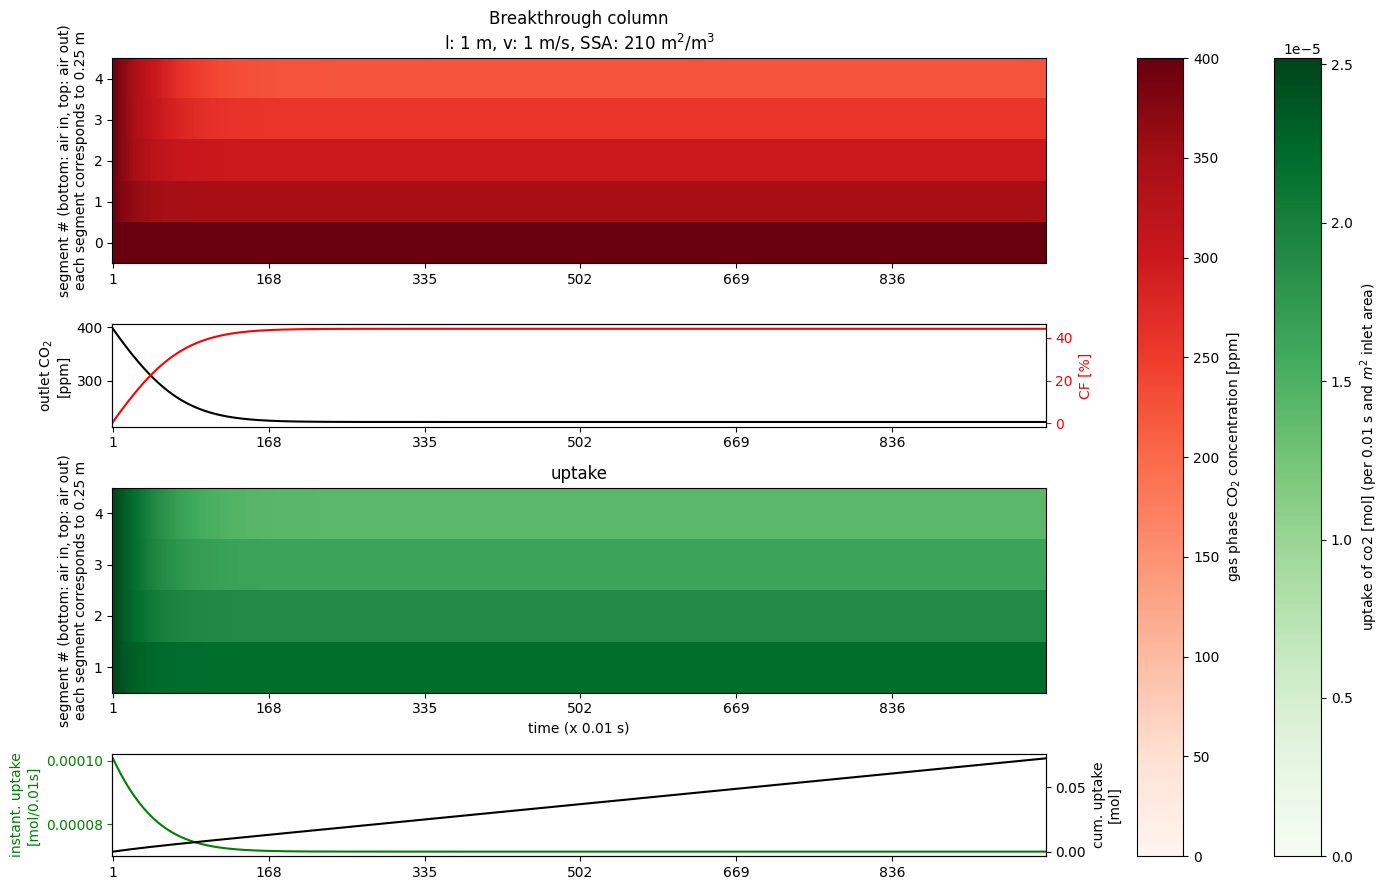

-----------------------------> new model run: N=40, dt=0.01
ds: 0.39999999999999997 [segments per timesteps], -> p: 1 [segments before inlet]
LAST STATE: CF=46.39%; inst. uptake=7.49e-05mol/timestep; calc-time=0.034s. size: 1000 timesteps x 41 segments


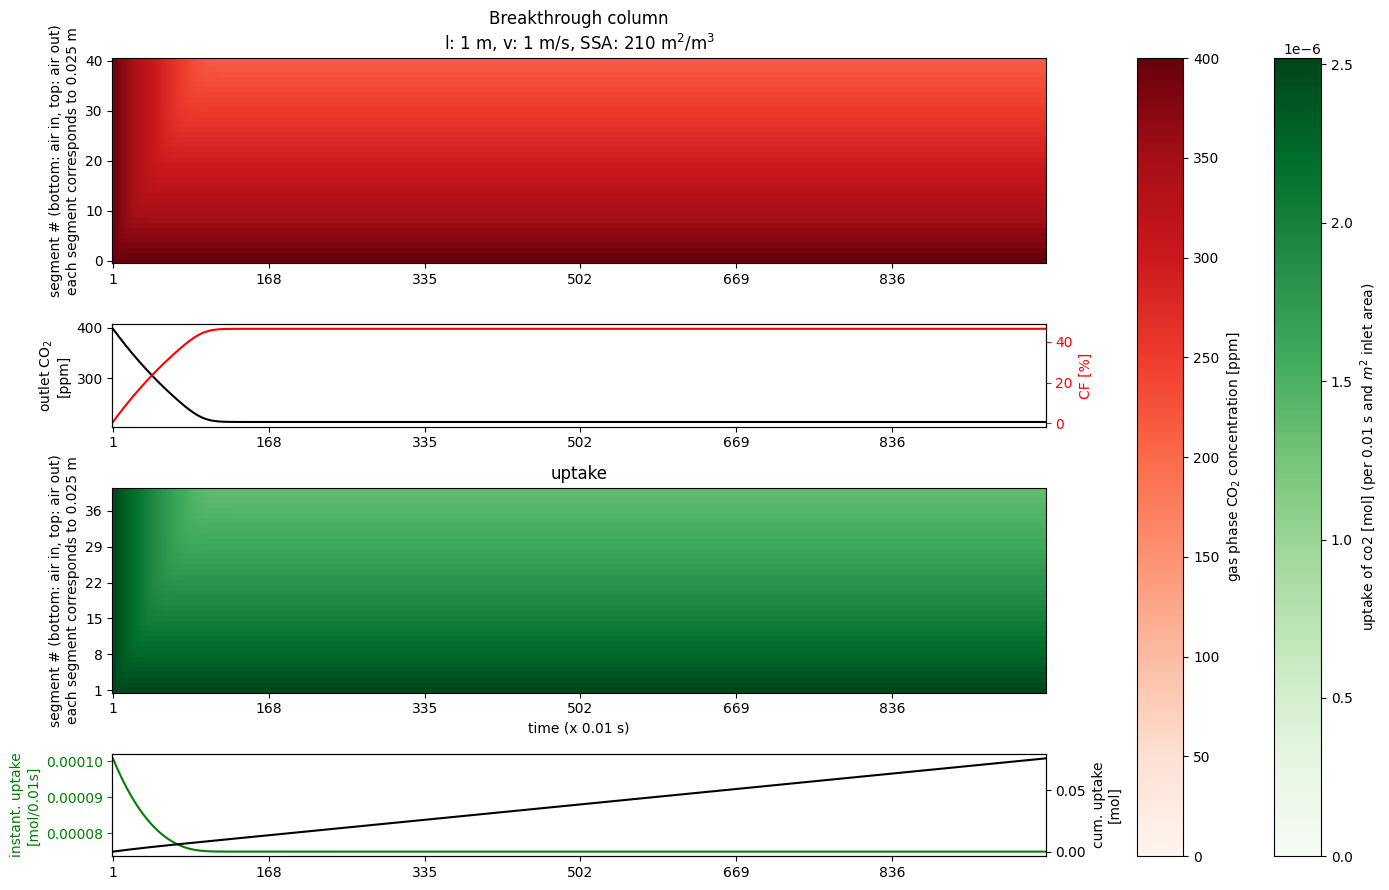

-----------------------------> new model run: N=400, dt=0.01
ds = 4.0 is integer.
ds: 4.0 [segments per timesteps], -> p: 4 [segments before inlet]
LAST STATE: CF=46.54%; inst. uptake=7.51e-05mol/timestep; calc-time=0.028s. size: 1000 timesteps x 404 segments


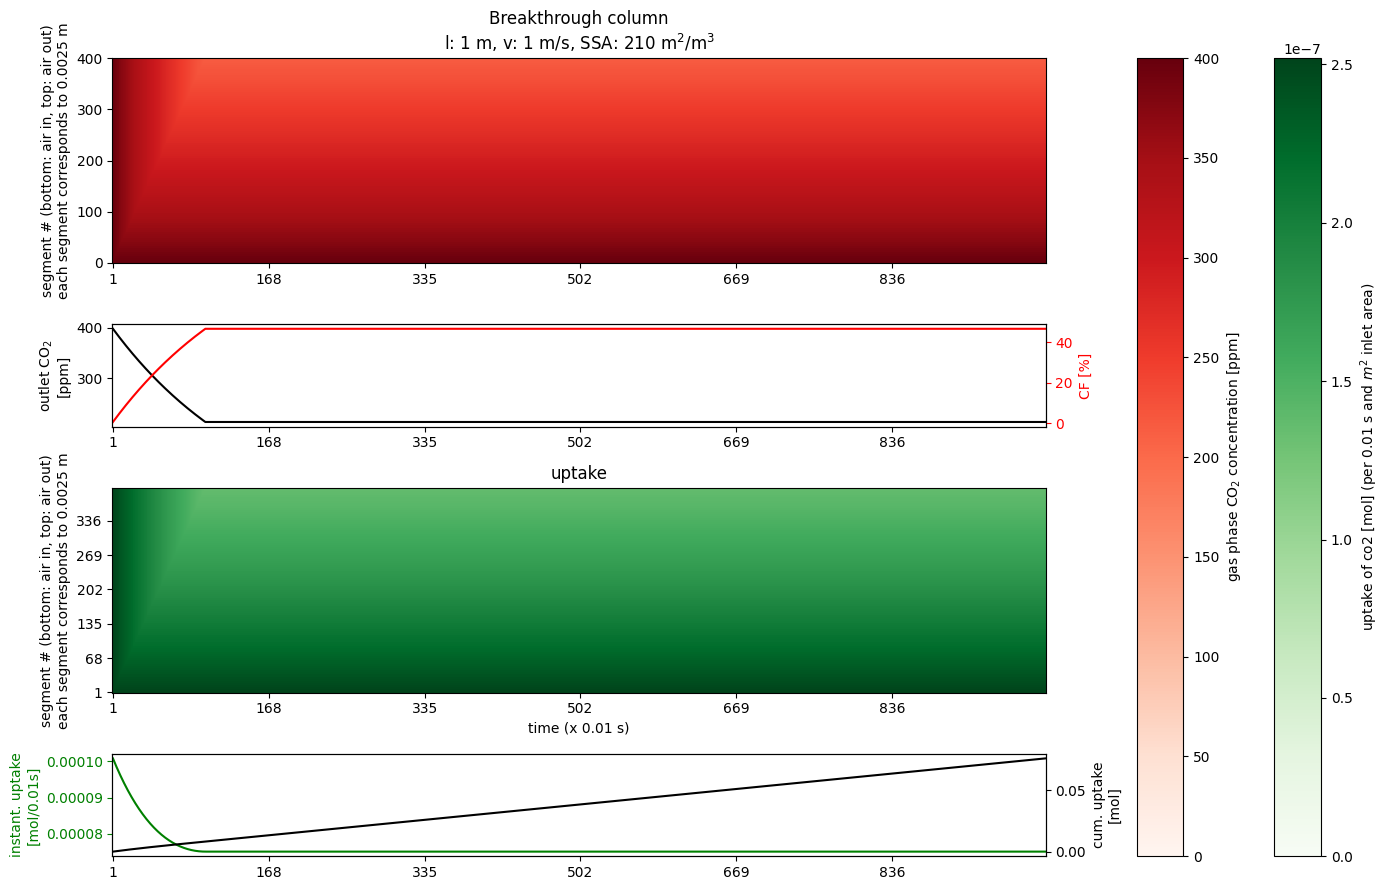

In [ ]:
# model parameters
# dt = 0.01 # time step [s]
# N = 40 # number of sections in the collumn
duration = 10 # s

# sorbent parameters
K_initial = 1.5 # initial mass transfer coefficient [mmol/(m^2 s kPa)]
#cap = 2.0 # cyclic uptake capacity [mol/L]

# process design parameters
l = 1 # collumn depth [m]
SSA = 210 # sorbent specific surface area [m^2/m^3]
eps = 0.8
# process operation parameters
v = 1 # air speed [m/s]
#V_liq = 0.5 # liquid sorbent volume [L]

for N in [4, 40, 400]:
    for dt in [0.01]:
        start = time.time()
        T = int(duration/dt) # total simulation time steps
        print(f"-----------------------------> new model run: N={N}, dt={dt}")

        x, n2l, n, ds = run_model(
            # sorbent parameters
            K_initial=K_initial,    # initial mass transfer coefficient [mmol/(m^2 s kPa)]

            # process design parameters
            l = l, # collumn depth [m]
            SSA = SSA, # sorbent specific surface area [m^2/m^3]
            # process operation parameters
            v = v, # air speed [m/s]
            eps = 0.8, # wetting efficiency [-] between 0 and 1

            # model parameters
            N = N, # number of sections in the collumn
            T = T, # total simulation time steps
            dt = dt, # time step [s]
            )

        
        cf = (400 - x[:, -1]*10) / 4 # capture fraction in %
        inst_uptake = np.sum(n2l, axis=1) # uptake in mol per timestep
        stop = time.time()
        print(f"LAST STATE: CF={cf[-1]:.2f}%; inst. uptake={inst_uptake[-1]:.3g}mol/timestep; calc-time={stop-start:.3f}s. size: {x.shape[0]} timesteps x {x.shape[1]} segments")



        plot_model_results(x, n2l, l, v, SSA, dt, ds)

-----------------------------> new model run: N=40, dt=1
ds = 40.0 is integer.
ds: 40.0 [segments per timesteps], -> p: 40 [segments before inlet]
LAST STATE: CF=62.43%; inst. uptake=0.0101mol/timestep; calc-time=0.001s. size: 10 timesteps x 80 segments


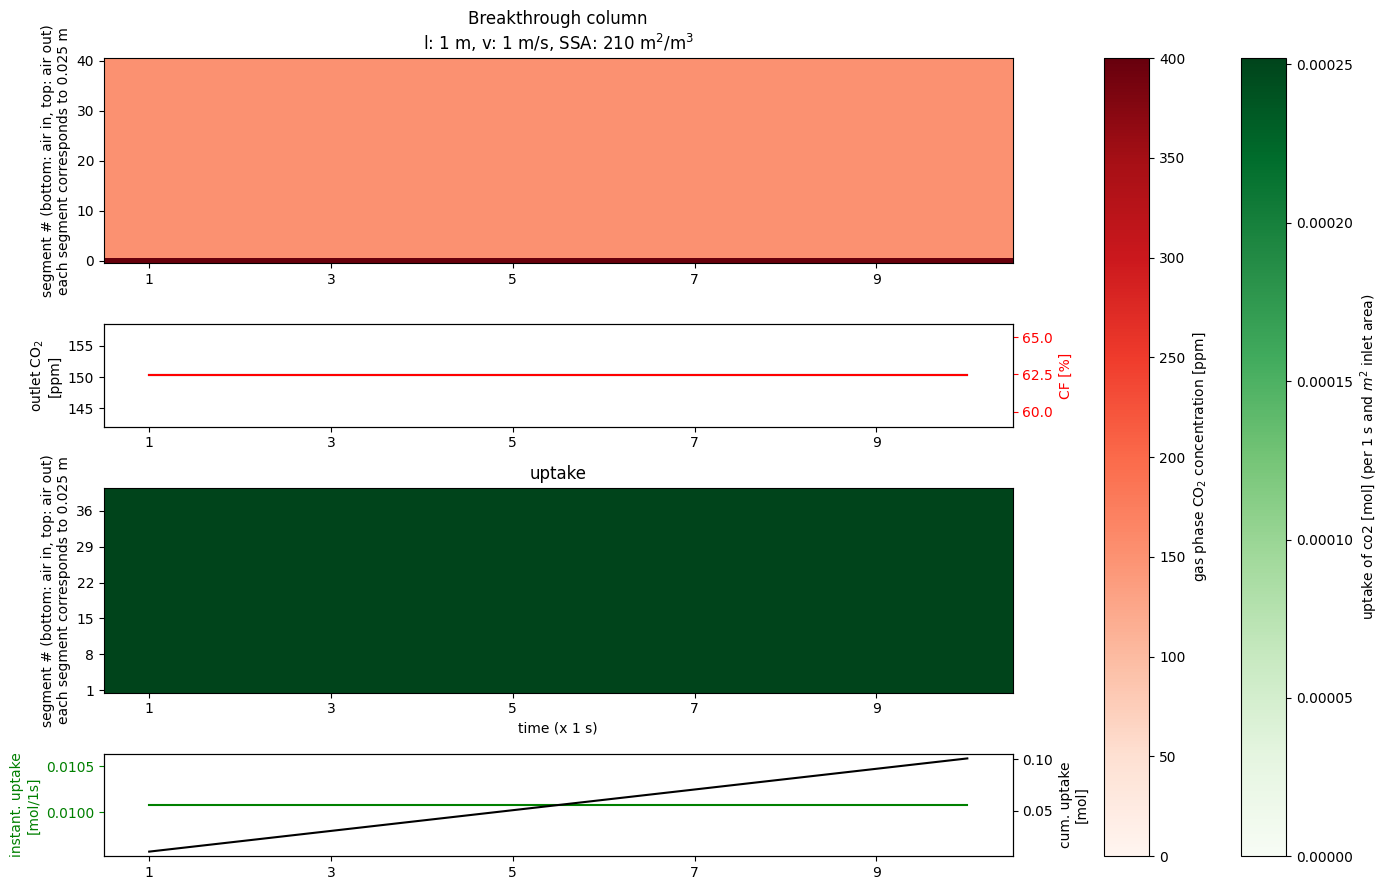

-----------------------------> new model run: N=40, dt=0.1
ds = 4.0 is integer.
ds: 4.0 [segments per timesteps], -> p: 4 [segments before inlet]
LAST STATE: CF=47.52%; inst. uptake=0.000767mol/timestep; calc-time=0.003s. size: 100 timesteps x 44 segments


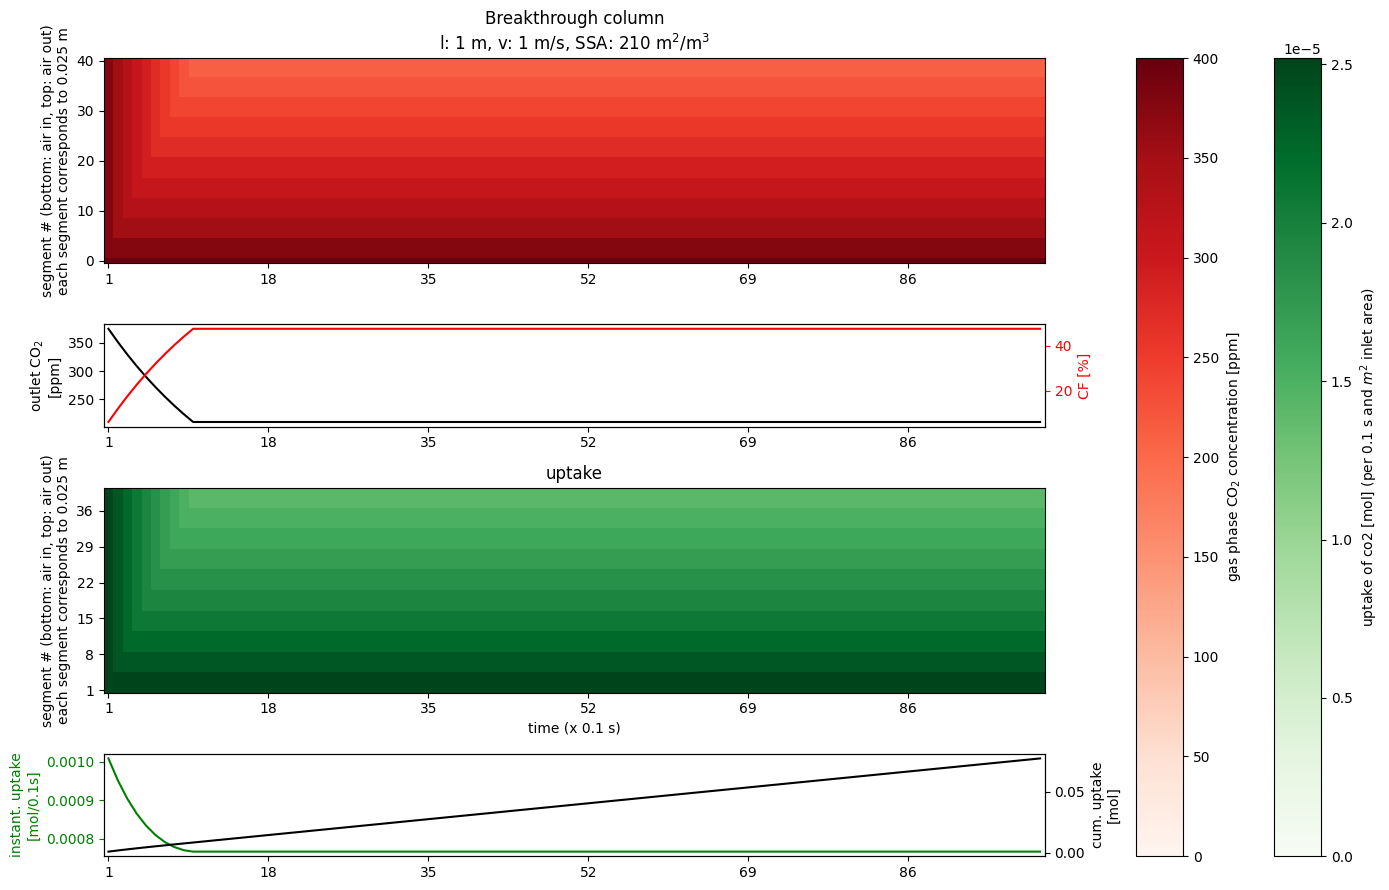

-----------------------------> new model run: N=40, dt=0.01
ds: 0.39999999999999997 [segments per timesteps], -> p: 1 [segments before inlet]
LAST STATE: CF=46.39%; inst. uptake=7.49e-05mol/timestep; calc-time=0.035s. size: 1000 timesteps x 41 segments


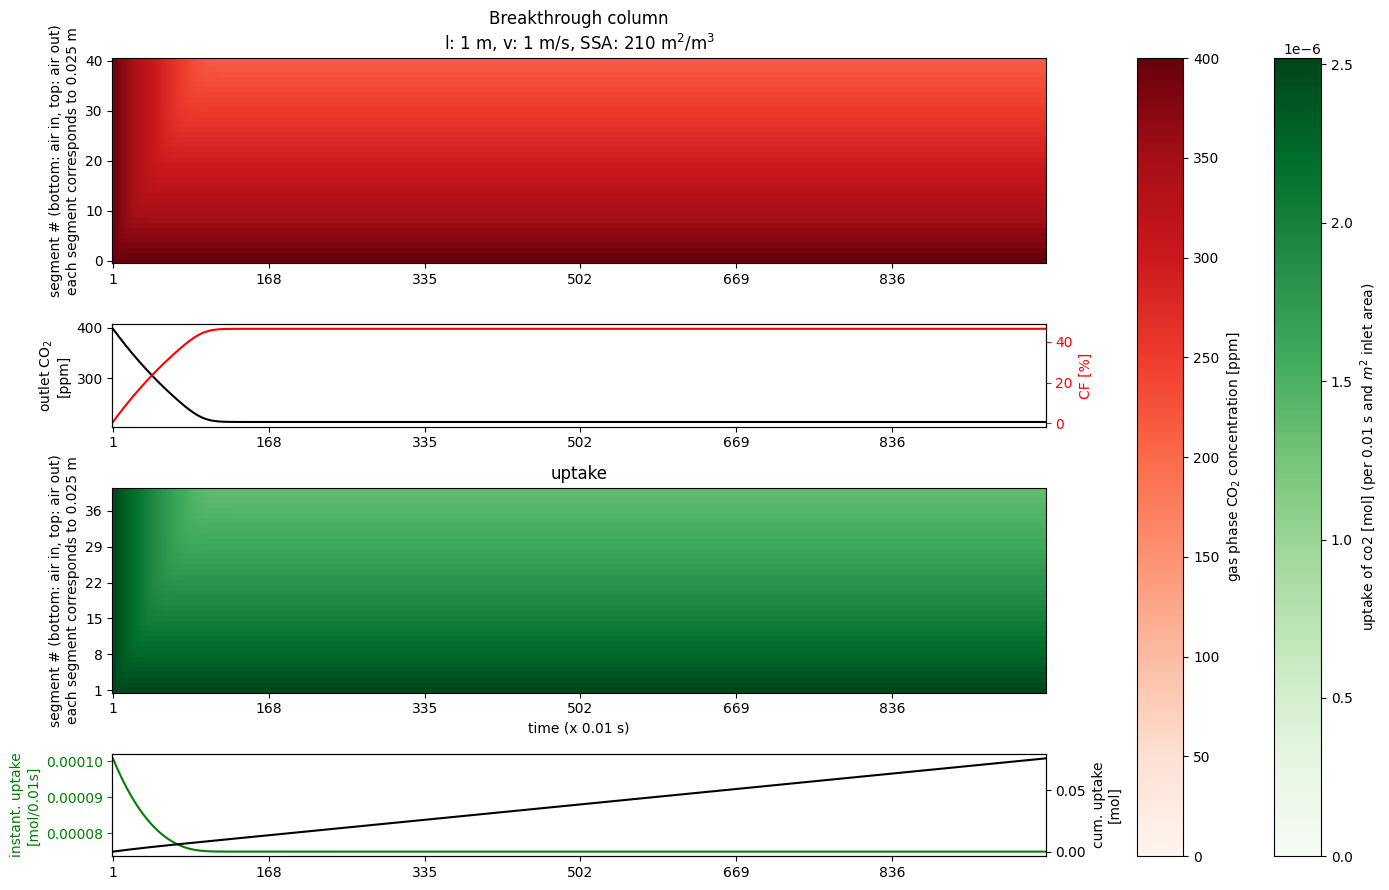

-----------------------------> new model run: N=40, dt=0.001
ds: 0.04 [segments per timesteps], -> p: 1 [segments before inlet]
LAST STATE: CF=46.20%; inst. uptake=7.46e-06mol/timestep; calc-time=0.357s. size: 10000 timesteps x 41 segments


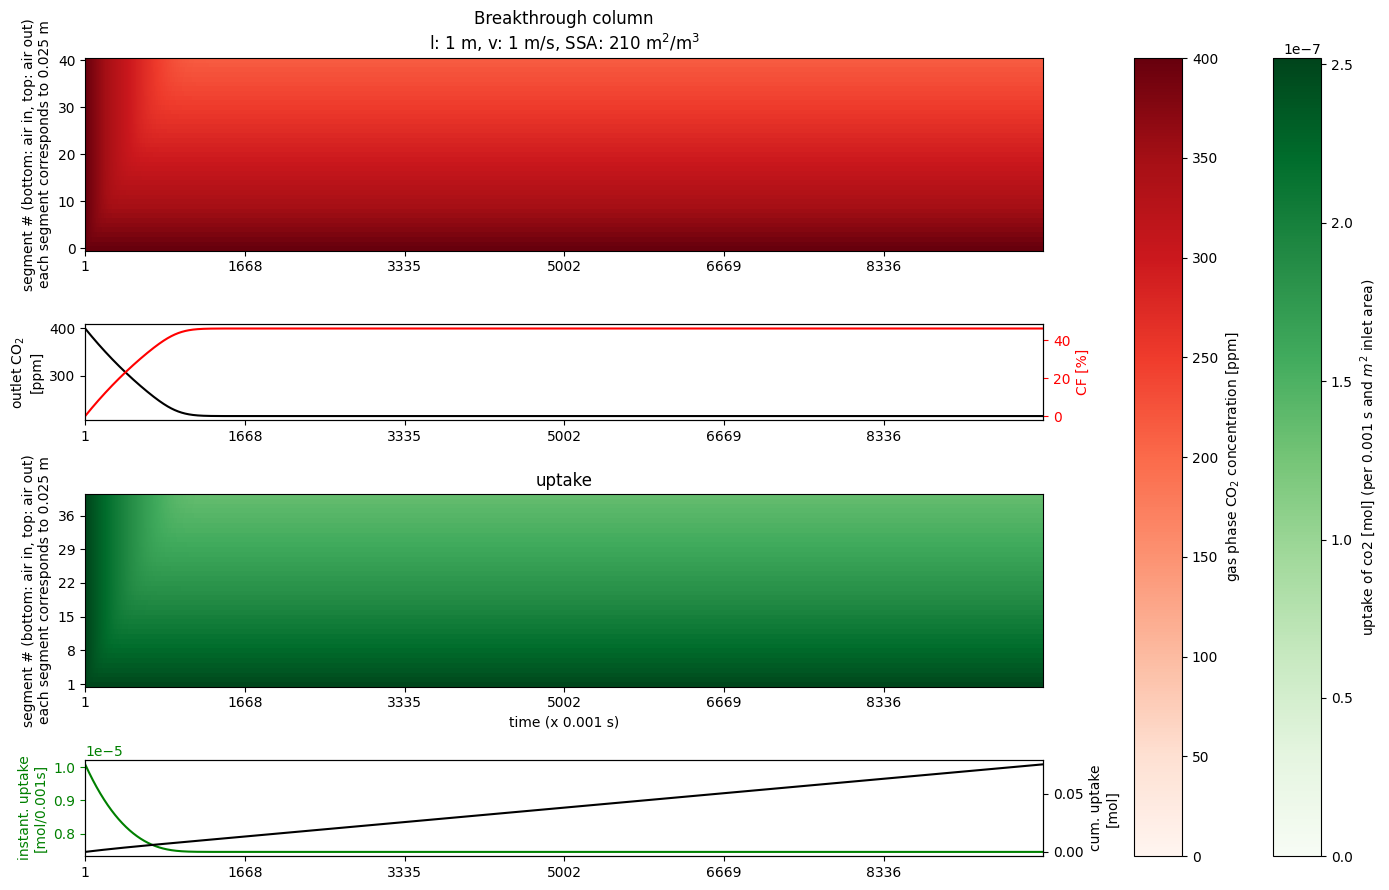

In [ ]:
# model parameters
# dt = 0.01 # time step [s]
# N = 40 # number of sections in the collumn
duration = 10 # s

# sorbent parameters
K_initial = 1.5 # initial mass transfer coefficient [mmol/(m^2 s kPa)]
#cap = 2.0 # cyclic uptake capacity [mol/L]

# process design parameters
l = 1 # collumn depth [m]
SSA = 210 # sorbent specific surface area [m^2/m^3]
eps = 0.8
# process operation parameters
v = 1 # air speed [m/s]
#V_liq = 0.5 # liquid sorbent volume [L]

for N in [40]:
    for dt in [1, 0.1, 0.01, 0.001]:
        start = time.time()
        T = int(duration/dt) # total simulation time steps
        print(f"-----------------------------> new model run: N={N}, dt={dt}")

        x, n2l, n, ds = run_model(
            # sorbent parameters
            K_initial=K_initial,    # initial mass transfer coefficient [mmol/(m^2 s kPa)]

            # process design parameters
            l = l, # collumn depth [m]
            SSA = SSA, # sorbent specific surface area [m^2/m^3]
            # process operation parameters
            v = v, # air speed [m/s]
            eps = 0.8, # wetting efficiency [-] between 0 and 1

            # model parameters
            N = N, # number of sections in the collumn
            T = T, # total simulation time steps
            dt = dt, # time step [s]
            )

        
        cf = (400 - x[:, -1]*10) / 4 # capture fraction in %
        inst_uptake = np.sum(n2l, axis=1) # uptake in mol per timestep
        stop = time.time()
        print(f"LAST STATE: CF={cf[-1]:.2f}%; inst. uptake={inst_uptake[-1]:.3g}mol/timestep; calc-time={stop-start:.3f}s. size: {x.shape[0]} timesteps x {x.shape[1]} segments")



        plot_model_results(x, n2l, l, v, SSA, dt, ds)

In [ ]:
cf

array([ 0.06243481,  0.12483065,  0.18718752, ..., 46.20069765,
       46.20069765, 46.20069765], shape=(10000,))